# Methylation branch

In [14]:
## Import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr
from scipy.fft import fft
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns

In [15]:
## Beta values test

X = pd.read_csv('beta.csv', index_col = 0)
cols = list(X.columns)
cols = cols[-3:] + cols[:-3]
X = X.loc[:,cols]
X = X.fillna(X.mean())
X = X.T
labels = pd.read_csv('ER_Patient_Data_Cleaned.csv', index_col = 0, header = 1)
labels['Numeric_Response'] = 0
labels.Numeric_Response[labels['endocrine response'] == "good"] = 1
y = labels["Numeric_Response"].astype('int')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
labels

{'index': 'Patients', 'value': 'Beta value', 'color': 'Response'}

In [3]:
unmatched_label = ["C00217","C00218","C00219","C00214","C00215","C00209"]

X_match = X.copy()
X_match = X_match.drop(unmatched_label)
y_match = y.copy()
y_match = y.drop(unmatched_label)

In [4]:
lymph_positive = ['MBN-1', 'MBN-5', 'MBN-6','MBN-41', 'MBN-11', 'MBN-44', 'MBN-47']

In [5]:
px.bar(X.loc[:,"cg17682313"],color=y)

NameError: name 'px' is not defined

In [ ]:
import plotly.express as px

px.bar(X_match.loc[:,"cg17682313"],color=y_match)

In [ ]:
good_cpg = []
poor_cpg = []

for val,label in zip(X.loc[:,"cg18629132"],labels['Grade ']):
    if label == 3: good_cpg.append(val)
    else: poor_cpg.append(val)
    

In [44]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

def oob_rf_params(X,y):

    RANDOM_STATE = 123

    # NOTE: Setting the `warm_start` construction parameter to `True` disables
    # support for parallelized ensembles but is necessary for tracking the OOB
    # error trajectory during training.
    ensemble_clfs = [
        (
            "RandomForestClassifier, max_features='sqrt'",
            RandomForestClassifier(
                warm_start=True,
                oob_score=True,
                max_features="sqrt",
                random_state=RANDOM_STATE,
            ),
        ),
        (
            "RandomForestClassifier, max_features='log2'",
            RandomForestClassifier(
                warm_start=True,
                max_features="log2",
                oob_score=True,
                random_state=RANDOM_STATE,
            ),
        ),
        (
            "RandomForestClassifier, max_features=None",
            RandomForestClassifier(
                warm_start=True,
                max_features=None,
                oob_score=True,
                random_state=RANDOM_STATE,
            ),
        ),
    ]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    # Range of `n_estimators` values to explore.
    min_estimators = 15
    max_estimators = 500

    min_oob_error = 1

    j = 0
    sqrt_error = []
    log2_error = []
    none_error = []
    
    for label, clf in ensemble_clfs:
        
        errors = [sqrt_error,log2_error,none_error]
        
        for i in range(min_estimators, max_estimators + 1, 5):
            clf.set_params(n_estimators=i)
            clf.fit(X, y)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            
            errors[j].append(oob_error)
            if oob_error < min_oob_error: 
                min_oob_error = oob_error
                best_estimators = i
                clf_best = str(clf[0])

            error_rate[label].append((i, oob_error))
        
        j += 1
        
    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()

    return min_oob_error, best_estimators, clf_best, errors

In [45]:
def iqr_features(X,thresh):

    iqr_X = iqr(X, axis = 0)
    iqr_X = iqr_X.reshape(1,len(X.columns))

    iqr_df = pd.DataFrame(iqr_X, columns = X.columns)

    X_iqr = X.append(iqr_df)
    X_iqr = X_iqr.rename(index={0: "IQR"})
        
    X_transposed = X_iqr.T
    new_X = X_transposed[X_transposed['IQR'] > thresh]
    X = new_X.drop('IQR', axis = 1).T
    
    X = new_X.drop('IQR', axis = 1).T
    
    return X, X.columns

k-fold:   0%|                                                                                    | 0/50 [00:00<?, ?it/s]

(20, 230)
0.1332179394647991
0.15415045676206182
0.1617971562526186
0.1779518212557611
0.13866613060136457
0.18327461571708117
0.18599718831842862
0.19257580936646373
0.15780230573304144
0.23707990049926225


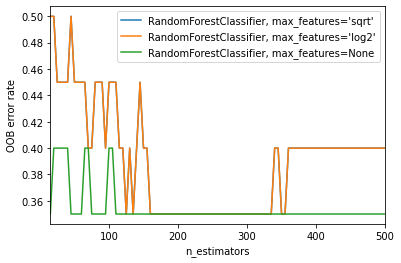

k-fold:   2%|█▌                                                                          | 1/50 [00:18<15:29, 18.98s/it]

0.35 125 sqrt
6 26
6 111
6 27
6 137
6 222
6 192
6 136
6 135
6 66
6 172
4 180
4 225
4 155
4 105
4 213
4 171
4 207
4 206
4 205
4 187
5 204
5 183
5 63
5 110
5 19
5 174
5 226
5 227
5 148
5 136
Prediction: [0.136 0.864] Real: 1

Prediction: [0.44 0.56] Real: 0

Prediction: [0.216 0.784] Real: 0

Prediction: [0.504 0.496] Real: 0

Prediction: [0.24 0.76] Real: 1

Prediction: [0.424 0.576] Real: 1

(21, 193)
0.12033709631882746
0.17224495749891694
0.1781370162868989
0.1467275503487078
0.159599906990617
0.19279274080153538
0.175975188940592
0.18313762698285882
0.2001685169266759
0.27747432398589483


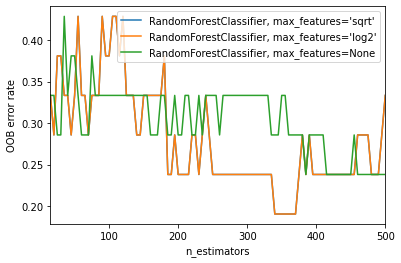

0.19047619047619047 340 sqrt


k-fold:   4%|███                                                                         | 2/50 [00:38<15:12, 19.02s/it]

1 28
1 160
1 185
1 177
1 152
1 192
1 117
1 174
1 46
1 144
2 29
2 35
2 148
2 181
2 64
2 175
2 28
2 120
2 72
2 172
6 3
6 135
6 189
6 139
6 26
6 25
6 160
6 72
6 141
6 181
Prediction: [0.71470588 0.28529412] Real: 0

Prediction: [0.79117647 0.20882353] Real: 0

Prediction: [0.54705882 0.45294118] Real: 1

Prediction: [0.76176471 0.23823529] Real: 1

Prediction: [0.37647059 0.62352941] Real: 1

(21, 398)
0.08588291203461353
0.11602113206158171
0.11794596480342731
0.11327265055084287
0.14564907444581635
0.11046393316437139
0.13591498205048871
0.1538864507227614
0.16054455811362492
0.16825476486386007


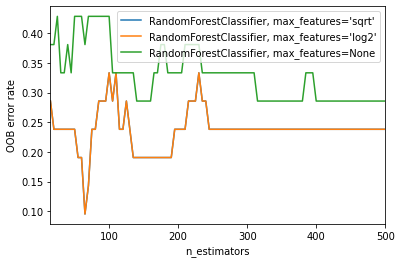

k-fold:   6%|████▌                                                                       | 3/50 [00:57<14:56, 19.07s/it]

0.09523809523809523 65 sqrt
8 235
8 110
8 264
8 17
8 298
8 393
8 394
8 77
8 2
8 70
6 131
6 376
6 248
6 166
6 120
6 139
6 243
6 77
6 179
6 341
2 325
2 223
2 342
2 307
2 315
2 297
2 366
2 171
2 286
2 287
Prediction: [0.61538462 0.38461538] Real: 0

Prediction: [0.75384615 0.24615385] Real: 0

Prediction: [0.49230769 0.50769231] Real: 1

Prediction: [0.49230769 0.50769231] Real: 1

Prediction: [0.47692308 0.52307692] Real: 1

(21, 244)
0.12234015408225603
0.11142687212792193
0.15879787175277094
0.15705751405893392
0.16641331395255887
0.20349343707140463
0.16706866789644592
0.1946886652075316
0.16738378158016576
0.1683894509100927


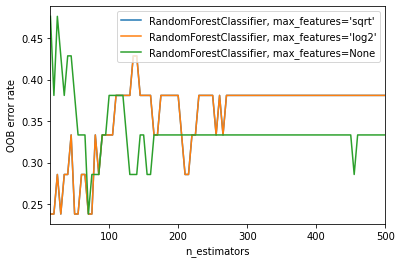

k-fold:   8%|██████                                                                      | 4/50 [01:17<14:51, 19.38s/it]

0.23809523809523814 15 sqrt
2 242
2 30
2 0
2 214
2 27
2 26
2 71
2 70
2 47
2 72
3 196
3 139
3 130
3 30
3 210
3 140
3 138
3 137
3 4
3 3
6 29
6 222
6 30
6 147
6 223
6 114
6 33
6 133
6 171
6 224
Prediction: [0.66666667 0.33333333] Real: 1

Prediction: [0.53333333 0.46666667] Real: 0

Prediction: [0.46666667 0.53333333] Real: 0

Prediction: [0.53333333 0.46666667] Real: 0

Prediction: [0.46666667 0.53333333] Real: 1

(21, 215)
0.09946452337498234
0.1575513515749756
0.159596402788048
0.20563451847198627
0.1690976950702273
0.1604699683125922
0.18699806967919375
0.17138877541300976
0.19110457281433776
0.17366716913458902


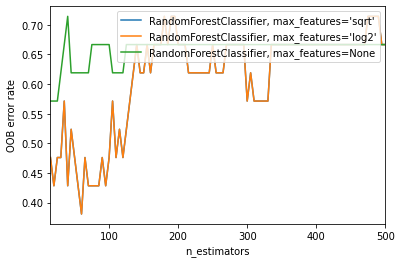

k-fold:  10%|███████▌                                                                    | 5/50 [01:37<14:48, 19.74s/it]

0.38095238095238093 60 sqrt
2 13
2 17
2 150
2 160
2 20
2 197
2 195
2 21
2 188
2 58
6 38
6 204
6 181
6 180
6 203
6 206
6 155
6 136
6 202
6 9
4 51
4 182
4 90
4 89
4 71
4 68
4 29
4 144
4 56
4 105
Prediction: [0.53333333 0.46666667] Real: 1

Prediction: [0.66666667 0.33333333] Real: 0

Prediction: [0.63333333 0.36666667] Real: 0

Prediction: [0.66666667 0.33333333] Real: 0

Prediction: [0.38333333 0.61666667] Real: 1

(20, 239)
0.10327106131280808
0.09130026276614847
0.17684671460423868
0.19829307705599014
0.1506496357738101
0.17468324498887075
0.14998380790519167
0.21303676026137947
0.20289583413999848
0.2072792276208001


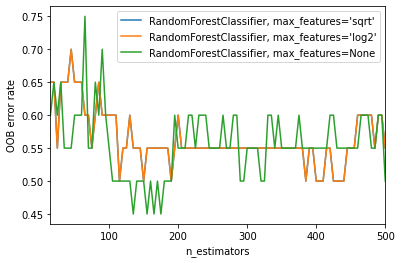

k-fold:  12%|█████████                                                                   | 6/50 [01:56<14:21, 19.58s/it]

0.44999999999999996 135 None
9 145
9 158
9 68
9 172
9 229
9 222
9 221
9 41
9 208
9 84
8 48
8 15
8 185
8 215
8 67
8 203
8 26
8 28
8 40
8 167
1 72
1 173
1 52
1 84
1 217
1 85
1 49
1 113
1 146
1 215
Prediction: [0.4 0.6] Real: 0

Prediction: [0.62222222 0.37777778] Real: 0

Prediction: [0.67407407 0.32592593] Real: 0

Prediction: [0.53333333 0.46666667] Real: 1

Prediction: [0.34814815 0.65185185] Real: 1

Prediction: [0.65925926 0.34074074] Real: 1

(21, 242)
0.12528137793813618
0.17325164858388895
0.13503121067378066
0.1399791743756376
0.17789671195394247
0.16730784299842372
0.1879158776032644
0.17308230765957228
0.17479371506105404
0.22833330527612714


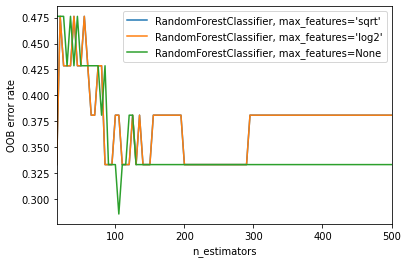

k-fold:  14%|██████████▋                                                                 | 7/50 [02:15<13:53, 19.38s/it]

0.2857142857142857 105 None
2 142
2 77
2 216
2 78
2 83
2 105
2 183
2 184
2 37
2 182
5 130
5 164
5 234
5 210
5 21
5 188
5 41
5 42
5 53
5 202
4 10
4 214
4 114
4 118
4 144
4 197
4 174
4 226
4 72
4 113
Prediction: [0.84761905 0.15238095] Real: 0

Prediction: [0.35238095 0.64761905] Real: 0

Prediction: [0.40952381 0.59047619] Real: 1

Prediction: [0.2952381 0.7047619] Real: 1

Prediction: [0.21904762 0.78095238] Real: 1

(21, 235)
0.12432525329218592
0.13349466715715655
0.11616077627213055
0.17697852165064756
0.16652133875753292
0.16309037441492968
0.1591749624594654
0.1805347319810975
0.1694182812314051
0.24955853080875198


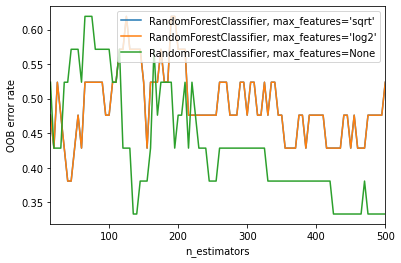

k-fold:  16%|████████████▏                                                               | 8/50 [02:34<13:29, 19.28s/it]

0.33333333333333337 135 None
6 226
6 58
6 212
6 54
6 55
6 219
6 56
6 28
6 198
6 29
8 111
8 5
8 15
8 52
8 139
8 21
8 110
8 68
8 48
8 27
0 102
0 82
0 81
0 62
0 99
0 113
0 231
0 94
0 2
0 32
Prediction: [0.54074074 0.45925926] Real: 1

Prediction: [0.65185185 0.34814815] Real: 0

Prediction: [0.74074074 0.25925926] Real: 0

Prediction: [0.65925926 0.34074074] Real: 1

Prediction: [0.74074074 0.25925926] Real: 1

(21, 144)
0.1478622483122805
0.17092163408578034
0.16602918458681554
0.20037350577803673
0.2120954833098155
0.17789322248847683
0.22081298672599461
0.27821394602668786
0.2155708634305738
0.2570644606227054


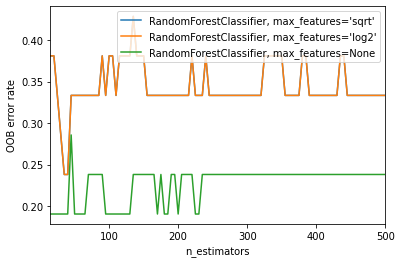

k-fold:  18%|█████████████▋                                                              | 9/50 [02:53<13:06, 19.19s/it]

0.19047619047619047 15 None
5 124
5 100
5 8
5 60
5 38
5 17
5 61
5 62
5 25
5 33
1 38
1 111
1 19
1 45
1 86
1 37
1 28
1 29
1 33
1 130
3 54
3 53
3 100
3 92
3 138
3 11
3 23
3 4
3 24
3 12
Prediction: [0.2 0.8] Real: 1

Prediction: [0.86666667 0.13333333] Real: 0

Prediction: [0.13333333 0.86666667] Real: 0

Prediction: [0.13333333 0.86666667] Real: 0

Prediction: [0.13333333 0.86666667] Real: 1

(21, 431)
0.07551408705038364
0.10443749716994188
0.12804312838536278
0.1260262996119919
0.12675336739162169
0.13129620762260957
0.13267375987646385
0.12098112290329542
0.14854604612376526
0.11950065416239869


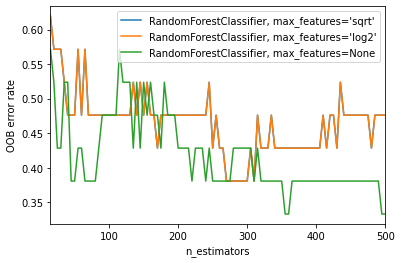

0.33333333333333337 355 None


k-fold:  20%|███████████████                                                            | 10/50 [03:12<12:48, 19.22s/it]

5 66
5 197
5 298
5 292
5 342
5 383
5 269
5 299
5 34
5 278
1 29
1 173
1 397
1 308
1 307
1 423
1 206
1 319
1 152
1 110
6 236
6 273
6 84
6 128
6 69
6 25
6 148
6 77
6 333
6 415
Prediction: [0.6 0.4] Real: 1

Prediction: [0.69859155 0.30140845] Real: 0

Prediction: [0.65352113 0.34647887] Real: 0

Prediction: [0.5915493 0.4084507] Real: 0

Prediction: [0.49295775 0.50704225] Real: 1

(20, 163)
0.14572388005188971
0.15000824016723605
0.17921108988618561
0.1532183793594325
0.16745022534892998
0.17086423173081294
0.1982548560764737
0.2023231663892289
0.18000912551871118
0.22859072009347312


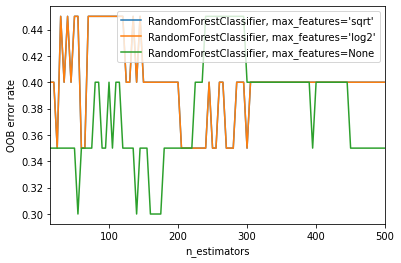

k-fold:  22%|████████████████▌                                                          | 11/50 [03:31<12:24, 19.08s/it]

0.30000000000000004 55 None
9 154
9 42
9 134
9 103
9 29
9 15
9 84
9 147
9 91
9 162
3 21
3 116
3 74
3 157
3 110
3 15
3 143
3 72
3 34
3 75
4 115
4 133
4 44
4 81
4 7
4 82
4 28
4 78
4 117
4 22
Prediction: [0.34545455 0.65454545] Real: 1

Prediction: [0.09090909 0.90909091] Real: 1

Prediction: [0.43636364 0.56363636] Real: 0

Prediction: [0.58181818 0.41818182] Real: 0

Prediction: [0.32727273 0.67272727] Real: 0

Prediction: [0.18181818 0.81818182] Real: 1

(21, 375)
0.09066006541318072
0.0815027902644423
0.13531735517826693
0.13561782879008952
0.13038499568457937
0.12295315160919942
0.14572395443033326
0.15965988490624555
0.17799936840249572
0.17422891347195824


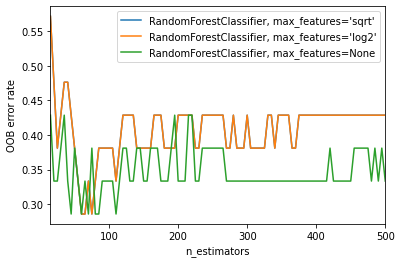

k-fold:  24%|██████████████████                                                         | 12/50 [03:51<12:10, 19.22s/it]

0.2857142857142857 60 sqrt
2 271
2 178
2 344
2 124
2 278
2 71
2 121
2 1
2 323
2 225
5 234
5 291
5 345
5 161
5 253
5 181
5 62
5 312
5 358
5 160
4 154
4 331
4 118
4 186
4 131
4 242
4 361
4 20
4 75
4 362
Prediction: [0.43333333 0.56666667] Real: 1

Prediction: [0.61666667 0.38333333] Real: 0

Prediction: [0.63333333 0.36666667] Real: 0

Prediction: [0.38333333 0.61666667] Real: 1

Prediction: [0.45 0.55] Real: 1

(21, 182)
0.14876406179662413
0.1023699138897247
0.1835005926010575
0.18345281304020278
0.17721632571351864
0.20314969931724894
0.21469629526396763
0.15297356765824419
0.20773274936732947
0.2033044219722084


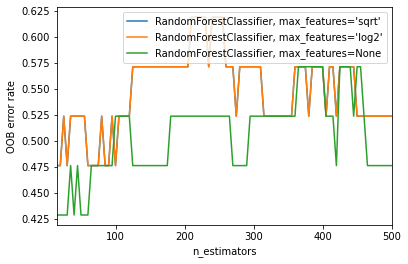

k-fold:  26%|███████████████████▌                                                       | 13/50 [04:10<11:49, 19.18s/it]

0.4285714285714286 15 None
8 112
8 142
8 18
8 164
8 89
8 67
8 92
8 179
8 180
8 52
2 52
2 127
2 13
2 74
2 1
2 73
2 72
2 124
2 36
2 29
3 81
3 144
3 48
3 137
3 51
3 145
3 122
3 121
3 15
3 156
Prediction: [0.66666667 0.33333333] Real: 0

Prediction: [0.73333333 0.26666667] Real: 0

Prediction: [0.6 0.4] Real: 1

Prediction: [0.2 0.8] Real: 1

Prediction: [0.66666667 0.33333333] Real: 1

(21, 247)
0.12176458320308776
0.0758680112720835
0.13880788889493773
0.1733119839675719
0.2033266568793931
0.16606530044804035
0.16590470617808156
0.14855208900524733
0.17045676988286346
0.1710054264162293


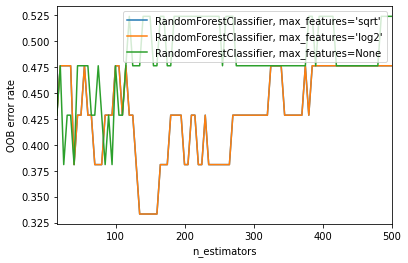

k-fold:  28%|█████████████████████                                                      | 14/50 [04:29<11:27, 19.09s/it]

0.33333333333333337 135 sqrt
4 69
4 82
4 191
4 38
4 163
4 64
4 169
4 129
4 192
4 61
5 93
5 144
5 87
5 4
5 46
5 164
5 194
5 69
5 182
5 1
7 26
7 209
7 84
7 95
7 177
7 27
7 234
7 96
7 191
7 210
Prediction: [0.59259259 0.40740741] Real: 0

Prediction: [0.38518519 0.61481481] Real: 0

Prediction: [0.64444444 0.35555556] Real: 0

Prediction: [0.34814815 0.65185185] Real: 1

Prediction: [0.33333333 0.66666667] Real: 1

(21, 315)
0.10932132891836435
0.09276820513716252
0.1595582906600507
0.16835691907042855
0.14664393127632838
0.15529414472066608
0.14721761725201205
0.1504285265411809
0.16697300766584694
0.17718507487592505


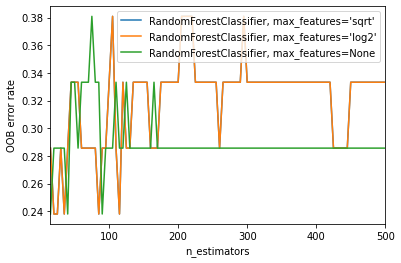

k-fold:  30%|██████████████████████▌                                                    | 15/50 [04:48<11:05, 19.01s/it]

0.23809523809523814 20 sqrt
0 129
0 115
0 141
0 116
0 126
0 140
0 87
0 290
0 20
0 44
9 266
9 293
9 188
9 307
9 37
9 175
9 267
9 251
9 124
9 0
4 100
4 72
4 302
4 299
4 283
4 41
4 111
4 69
4 199
4 66
Prediction: [0.5 0.5] Real: 0

Prediction: [0.4 0.6] Real: 0

Prediction: [0.85 0.15] Real: 0

Prediction: [0.3 0.7] Real: 1

Prediction: [0.5 0.5] Real: 1

(20, 332)
0.10138441887493722
0.09068430410613988
0.1190697432988708
0.14924928178440988
0.1308831734678507
0.16947126983741065
0.12228177589435445
0.19224322859828402
0.1551557610287221
0.16687622621602882


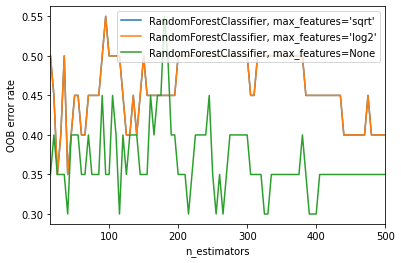

k-fold:  32%|████████████████████████                                                   | 16/50 [05:06<10:43, 18.93s/it]

0.30000000000000004 40 None
3 35
3 37
3 144
3 302
3 281
3 38
3 1
3 63
3 58
3 297
1 302
1 192
1 251
1 197
1 10
1 190
1 67
1 11
1 296
1 191
7 75
7 323
7 181
7 156
7 90
7 211
7 106
7 109
7 219
7 110
Prediction: [0.45 0.55] Real: 1

Prediction: [0.675 0.325] Real: 0

Prediction: [0.5 0.5] Real: 0

Prediction: [0.725 0.275] Real: 0

Prediction: [0.6 0.4] Real: 1

Prediction: [0.775 0.225] Real: 1

(21, 346)
0.10514904075701394
0.08977707750619154
0.12332449743115467
0.14091606634705298
0.1400913399978428
0.14567769002052064
0.13312761952620783
0.1667179038062849
0.1892752395307474
0.1568864797439882


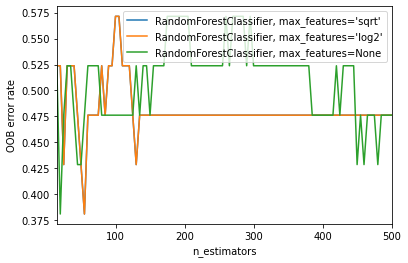

k-fold:  34%|█████████████████████████▌                                                 | 17/50 [05:25<10:24, 18.93s/it]

0.38095238095238093 55 sqrt
7 289
7 120
7 4
7 37
7 172
7 193
7 315
7 314
7 59
7 313
0 312
0 84
0 262
0 146
0 180
0 144
0 148
0 147
0 145
0 158
9 305
9 261
9 76
9 280
9 241
9 9
9 269
9 324
9 218
9 216
Prediction: [0.6 0.4] Real: 1

Prediction: [0.67272727 0.32727273] Real: 0

Prediction: [0.8 0.2] Real: 0

Prediction: [0.4 0.6] Real: 1

Prediction: [0.47272727 0.52727273] Real: 1

(21, 148)
0.15550452804662718
0.16986395057594544
0.1740403143178781
0.18802683060076988
0.1507460278304564
0.190919313819688
0.2011320943746364
0.20733554417100078
0.24040086399946917
0.33330700070713876


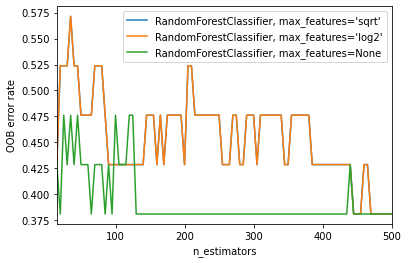

0.38095238095238093 445 sqrt


k-fold:  36%|███████████████████████████                                                | 18/50 [05:45<10:10, 19.09s/it]

5 58
5 127
5 5
5 4
5 86
5 44
5 105
5 77
5 146
5 94
9 140
9 134
9 16
9 45
9 103
9 91
9 35
9 81
9 15
9 133
3 5
3 47
3 77
3 137
3 91
3 11
3 115
3 34
3 146
3 59
Prediction: [0.31460674 0.68539326] Real: 1

Prediction: [0.78202247 0.21797753] Real: 0

Prediction: [0.45168539 0.54831461] Real: 0

Prediction: [0.60674157 0.39325843] Real: 1

Prediction: [0.32808989 0.67191011] Real: 1

(21, 180)
0.14331480029003568
0.16020801837939327
0.15710581423350575
0.17297548781747
0.20583292934876812
0.1917233605540437
0.19947054236567272
0.19466448033855963
0.16402354980129522
0.1994548158142915


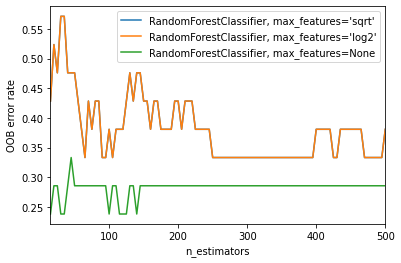

k-fold:  38%|████████████████████████████▌                                              | 19/50 [06:03<09:49, 19.00s/it]

0.23809523809523814 15 None
0 92
0 5
0 168
0 81
0 93
0 151
0 53
0 78
0 178
0 63
9 56
9 2
9 1
9 4
9 3
9 135
9 143
9 17
9 125
9 23
4 35
4 139
4 47
4 87
4 122
4 165
4 8
4 30
4 86
4 99
Prediction: [1. 0.] Real: 0

Prediction: [0.93333333 0.06666667] Real: 0

Prediction: [0.53333333 0.46666667] Real: 0

Prediction: [0.06666667 0.93333333] Real: 1

Prediction: [0.06666667 0.93333333] Real: 1

(21, 313)
0.10760735054217563
0.06651954995524413
0.151960962467049
0.1702575442410702
0.1457344472938621
0.15903387231323365
0.15610623348046704
0.14373132450574355
0.12367394812747562
0.12717239627786614


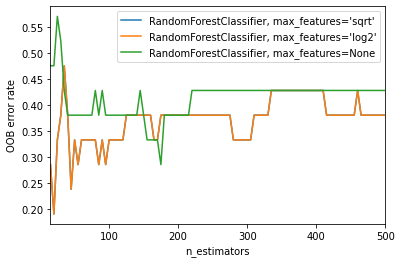

k-fold:  40%|██████████████████████████████                                             | 20/50 [06:22<09:29, 18.98s/it]

0.19047619047619047 20 sqrt
5 261
5 244
5 194
5 291
5 290
5 157
5 280
5 217
5 108
5 271
2 270
2 12
2 60
2 89
2 77
2 27
2 296
2 225
2 226
2 295
4 256
4 238
4 257
4 255
4 133
4 52
4 248
4 241
4 134
4 210
Prediction: [0.4 0.6] Real: 0

Prediction: [0.4 0.6] Real: 0

Prediction: [0.35 0.65] Real: 0

Prediction: [0.2 0.8] Real: 1

Prediction: [0.45 0.55] Real: 1

(20, 230)
0.12553399051840577
0.1089117854853451
0.15772303762919837
0.18665482893086394
0.1659694877013374
0.1668482384403424
0.18837834489021965
0.17639367995006128
0.21091528969394985
0.18260750393325384


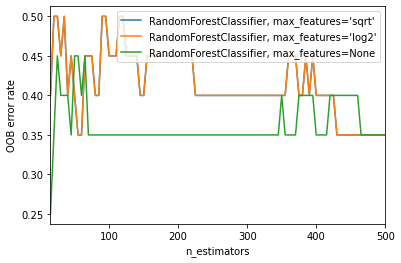

k-fold:  42%|███████████████████████████████▌                                           | 21/50 [06:41<09:09, 18.94s/it]

0.25 15 None
4 150
4 151
4 192
4 91
4 139
4 183
4 208
4 75
4 140
4 109
6 122
6 24
6 160
6 109
6 50
6 58
6 194
6 145
6 209
6 202
3 137
3 42
3 202
3 91
3 73
3 74
3 70
3 72
3 206
3 40
Prediction: [0.4 0.6] Real: 1

Prediction: [0.6 0.4] Real: 0

Prediction: [0.4 0.6] Real: 0

Prediction: [0.53333333 0.46666667] Real: 0

Prediction: [0.26666667 0.73333333] Real: 1

Prediction: [0.33333333 0.66666667] Real: 1

(21, 199)
0.07856092851879568
0.1497120812990846
0.16037518712240068
0.18281298924773912
0.13138563560592895
0.20189156290686605
0.17538294619361627
0.1776617616608047
0.17754741774456914
0.1841135737545495


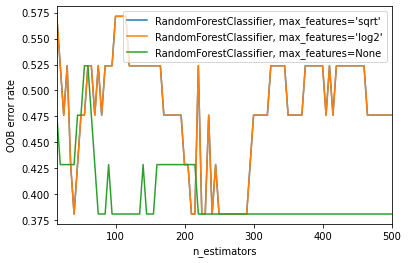

k-fold:  44%|█████████████████████████████████                                          | 22/50 [07:00<08:50, 18.94s/it]

0.38095238095238093 40 sqrt
1 113
1 4
1 27
1 69
1 165
1 8
1 171
1 172
1 98
1 47
0 10
0 173
0 104
0 147
0 106
0 151
0 49
0 1
0 94
0 46
5 119
5 74
5 6
5 129
5 66
5 171
5 121
5 154
5 15
5 38
Prediction: [0.65 0.35] Real: 1

Prediction: [0.575 0.425] Real: 0

Prediction: [0.7 0.3] Real: 0

Prediction: [0.575 0.425] Real: 1

Prediction: [0.65 0.35] Real: 1

(21, 272)
0.1134158439105454
0.13141925787640618
0.13849649891443253
0.1447002189279252
0.14542711197533773
0.16470203929479074
0.15415632861949705
0.16800699712687064
0.1480053900953066
0.16628835920490084


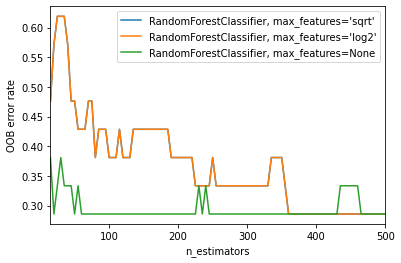

0.2857142857142857 360 sqrt


k-fold:  46%|██████████████████████████████████▌                                        | 23/50 [07:20<08:37, 19.17s/it]

0 262
0 114
0 96
0 122
0 70
0 113
0 112
0 110
0 109
0 12
2 87
2 88
2 181
2 249
2 93
2 35
2 252
2 94
2 89
2 58
4 57
4 31
4 214
4 166
4 236
4 120
4 121
4 32
4 15
4 49
Prediction: [0.74166667 0.25833333] Real: 0

Prediction: [0.42222222 0.57777778] Real: 0

Prediction: [0.33333333 0.66666667] Real: 1

Prediction: [0.49444444 0.50555556] Real: 1

Prediction: [0.79444444 0.20555556] Real: 1

(21, 257)
0.12351705239981778
0.06914030385092859
0.15364060547797054
0.14869754137364963
0.15632921449929987
0.18069201894157655
0.18317165730236742
0.1458899106352147
0.16080352300078662
0.2666270089172378


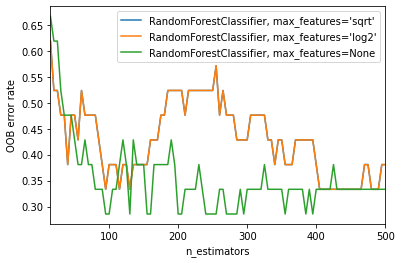

k-fold:  48%|████████████████████████████████████                                       | 24/50 [07:39<08:15, 19.07s/it]

0.2857142857142857 95 None
2 153
2 171
2 238
2 54
2 186
2 21
2 70
2 2
2 177
2 188
9 18
9 34
9 155
9 19
9 251
9 162
9 63
9 212
9 25
9 192
6 236
6 94
6 218
6 174
6 195
6 50
6 23
6 42
6 173
6 66
Prediction: [0.25263158 0.74736842] Real: 1

Prediction: [0.64210526 0.35789474] Real: 0

Prediction: [0.65263158 0.34736842] Real: 0

Prediction: [0.66315789 0.33684211] Real: 0

Prediction: [0.8 0.2] Real: 1

(21, 282)
0.11119620052464933
0.09560020888183303
0.17205491396501668
0.17023867359616468
0.1285880934660032
0.16940828762867866
0.15390869252320732
0.17155772721285234
0.1407226777620591
0.19918521246361648


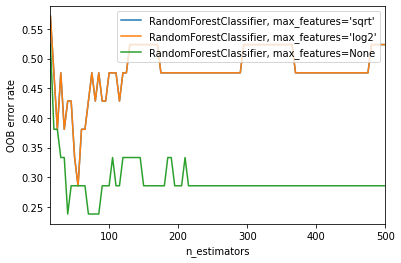

k-fold:  50%|█████████████████████████████████████▌                                     | 25/50 [07:58<07:56, 19.04s/it]

0.23809523809523814 40 None
8 76
8 249
8 172
8 99
8 84
8 160
8 278
8 16
8 137
8 74
0 259
0 126
0 118
0 117
0 132
0 114
0 144
0 145
0 48
0 47
5 40
5 129
5 69
5 10
5 202
5 58
5 136
5 209
5 133
5 89
Prediction: [0.8 0.2] Real: 0

Prediction: [0.725 0.275] Real: 0

Prediction: [0.275 0.725] Real: 0

Prediction: [0.325 0.675] Real: 1

Prediction: [0.175 0.825] Real: 1

(20, 360)
0.07454971852238676
0.12163665052272266
0.12977081176672656
0.1396771588780052
0.11655592916837049
0.15640236398265311
0.12084078559166421
0.13179248835380095
0.15886905935299447
0.16072228371452665


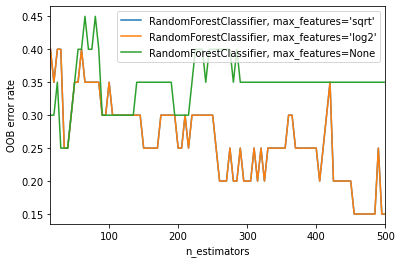

0.15000000000000002 455 sqrt


k-fold:  52%|███████████████████████████████████████                                    | 26/50 [08:18<07:44, 19.36s/it]

3 226
3 306
3 304
3 229
3 10
3 316
3 324
3 153
3 90
3 154
7 125
7 253
7 9
7 251
7 314
7 80
7 327
7 90
7 62
7 219
4 342
4 177
4 245
4 297
4 49
4 307
4 125
4 285
4 309
4 92
Prediction: [0.37362637 0.62637363] Real: 1

Prediction: [0.4043956 0.5956044] Real: 0

Prediction: [0.8021978 0.1978022] Real: 0

Prediction: [0.81538462 0.18461538] Real: 0

Prediction: [0.61978022 0.38021978] Real: 1

Prediction: [0.74725275 0.25274725] Real: 1

(21, 214)
0.1418363996119521
0.12005541535870501
0.16472312971396758
0.1943952163677005
0.18173928237561332
0.1969457276312757
0.16315347054494614
0.16648132689976108
0.21332548683335004
0.1735051081535661


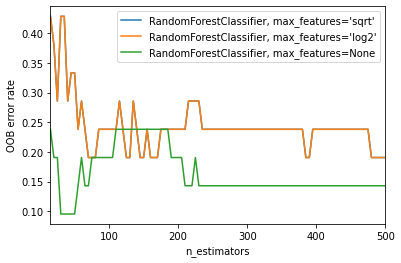

k-fold:  54%|████████████████████████████████████████▌                                  | 27/50 [08:37<07:22, 19.25s/it]

0.09523809523809523 30 None
3 203
3 147
3 160
3 35
3 57
3 168
3 77
3 125
3 182
3 135
9 44
9 208
9 70
9 3
9 75
9 48
9 9
9 100
9 196
9 29
5 201
5 64
5 149
5 109
5 204
5 99
5 12
5 90
5 89
5 123
Prediction: [0.43333333 0.56666667] Real: 0

Prediction: [0.96666667 0.03333333] Real: 0

Prediction: [0.13333333 0.86666667] Real: 1

Prediction: [0.23333333 0.76666667] Real: 1

Prediction: [0.16666667 0.83333333] Real: 1

(21, 229)
0.12738119214799054
0.14190425028743148
0.148500436193521
0.18100394329240135
0.20034075969510617
0.14909355655386838
0.15304442517424913
0.17797352452616505
0.23757535014499112
0.1953156895539187


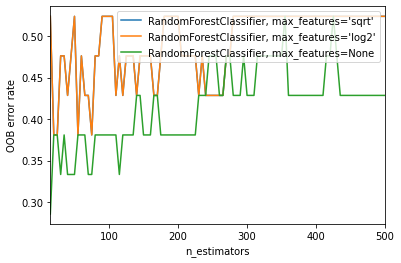

k-fold:  56%|██████████████████████████████████████████                                 | 28/50 [08:56<07:04, 19.29s/it]

0.2857142857142857 15 None
4 86
4 52
4 142
4 209
4 42
4 12
4 105
4 76
4 106
4 118
7 136
7 74
7 110
7 164
7 47
7 48
7 215
7 225
7 111
7 141
0 99
0 162
0 98
0 142
0 122
0 67
0 20
0 192
0 10
0 15
Prediction: [0.73333333 0.26666667] Real: 0

Prediction: [0.33333333 0.66666667] Real: 0

Prediction: [0.13333333 0.86666667] Real: 1

Prediction: [0.53333333 0.46666667] Real: 1

Prediction: [0.53333333 0.46666667] Real: 1

(21, 299)
0.11847986553230253
0.08045288370316497
0.13366231415880464
0.1500664991438068
0.15544081289721512
0.15298946745378436
0.14204275935233981
0.1893780946858588
0.17382171822828982
0.1952895014931078


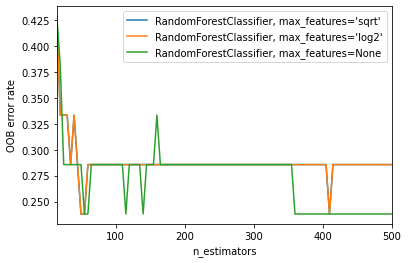

k-fold:  58%|███████████████████████████████████████████▌                               | 29/50 [09:15<06:42, 19.18s/it]

0.23809523809523814 50 sqrt
4 136
4 233
4 50
4 134
4 218
4 139
4 123
4 122
4 18
4 237
6 136
6 85
6 61
6 260
6 285
6 119
6 187
6 182
6 95
6 39
9 140
9 14
9 291
9 292
9 36
9 37
9 245
9 86
9 76
9 35
Prediction: [0.42 0.58] Real: 1

Prediction: [0.18 0.82] Real: 1

Prediction: [0.32 0.68] Real: 0

Prediction: [0.28 0.72] Real: 0

Prediction: [0.42 0.58] Real: 0

(21, 185)
0.1319699850987624
0.1659548113048401
0.1421367133900262
0.1918594259815853
0.20149112780681924
0.184071851158203
0.23698776571648758
0.22528026844826166
0.18391641801471617
0.22735478802554196


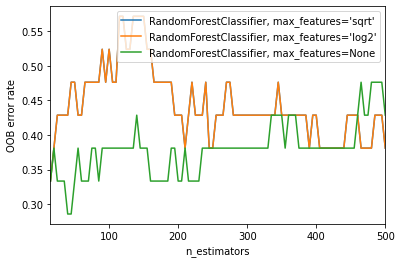

k-fold:  60%|█████████████████████████████████████████████                              | 30/50 [09:34<06:22, 19.13s/it]

0.2857142857142857 40 None
0 78
0 142
0 69
0 47
0 63
0 70
0 172
0 182
0 72
0 77
6 5
6 85
6 165
6 46
6 90
6 180
6 181
6 110
6 150
6 50
4 166
4 26
4 0
4 110
4 118
4 37
4 139
4 168
4 167
4 112
Prediction: [0.85 0.15] Real: 0

Prediction: [0.925 0.075] Real: 0

Prediction: [0.25 0.75] Real: 0

Prediction: [0.6 0.4] Real: 1

Prediction: [0.625 0.375] Real: 1

(20, 249)
0.15091115236163302
0.12430695598921974
0.1514802083186373
0.14956352543589496
0.1618266487224701
0.16082930696282485
0.16465706577199343
0.13752514939652474
0.14471752750430875
0.1931928603127886


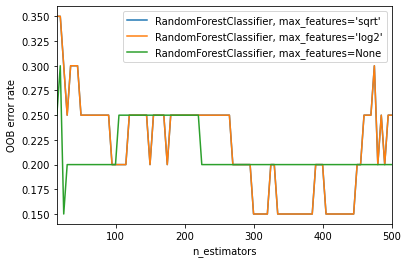

0.15000000000000002 300 sqrt


k-fold:  62%|██████████████████████████████████████████████▌                            | 31/50 [09:53<06:03, 19.13s/it]

0 47
0 229
0 222
0 5
0 46
0 244
0 167
0 12
0 102
0 63
5 118
5 29
5 240
5 190
5 220
5 108
5 145
5 210
5 238
5 84
3 154
3 196
3 175
3 174
3 81
3 13
3 31
3 206
3 224
3 30
Prediction: [0.26666667 0.73333333] Real: 1

Prediction: [0.35666667 0.64333333] Real: 0

Prediction: [0.66333333 0.33666667] Real: 0

Prediction: [0.61666667 0.38333333] Real: 0

Prediction: [0.75 0.25] Real: 1

Prediction: [0.44 0.56] Real: 1

(21, 248)
0.11366695839652347
0.09997718912249186
0.17442483047539592
0.1378925461127512
0.1523072945485644
0.17941822309673244
0.15425490047289162
0.24716572368428957
0.1657741043767239
0.1760730132561519


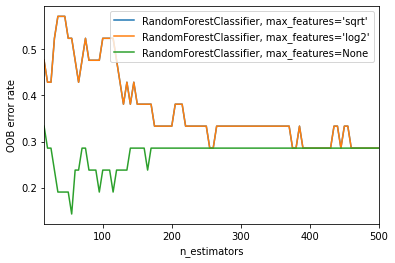

k-fold:  64%|████████████████████████████████████████████████                           | 32/50 [10:12<05:42, 19.01s/it]

0.1428571428571429 55 None
7 168
7 24
7 187
7 219
7 239
7 119
7 49
7 173
7 65
7 240
6 61
6 145
6 29
6 208
6 11
6 17
6 111
6 200
6 197
6 165
5 200
5 179
5 108
5 20
5 120
5 77
5 27
5 38
5 8
5 163
Prediction: [0.43636364 0.56363636] Real: 1

Prediction: [0.81818182 0.18181818] Real: 0

Prediction: [0.81818182 0.18181818] Real: 0

Prediction: [0.69090909 0.30909091] Real: 1

Prediction: [0.81818182 0.18181818] Real: 1

(21, 189)
0.13824827269564927
0.14409386835466034
0.1418750421366173
0.1779593967216433
0.1481313363127517
0.256406957866575
0.177516457130177
0.22260021876587047
0.176812090321703
0.19159913580334526


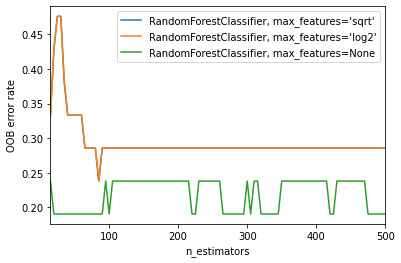

k-fold:  66%|█████████████████████████████████████████████████▌                         | 33/50 [10:31<05:23, 19.01s/it]

0.19047619047619047 20 None
9 49
9 88
9 3
9 30
9 152
9 135
9 86
9 121
9 140
9 18
8 60
8 79
8 70
8 6
8 85
8 69
8 21
8 153
8 138
8 46
5 29
5 78
5 109
5 122
5 49
5 108
5 103
5 77
5 91
5 76
Prediction: [0.9 0.1] Real: 1

Prediction: [0.9 0.1] Real: 0

Prediction: [0.9 0.1] Real: 0

Prediction: [0.1 0.9] Real: 1

Prediction: [0.5 0.5] Real: 1

(21, 347)
0.10139716456054766
0.07654527304013312
0.12232315159994339
0.15374417240318036
0.14756281562155726
0.11877199484563163
0.1404018132699214
0.14937159480304874
0.16911440920484333
0.18060767265680452


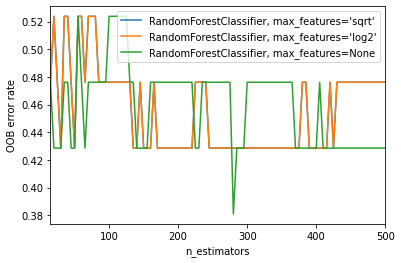

0.38095238095238093 280 None


k-fold:  68%|███████████████████████████████████████████████████                        | 34/50 [10:50<05:04, 19.02s/it]

4 60
4 276
4 74
4 270
4 330
4 109
4 273
4 114
4 272
4 248
5 41
5 93
5 293
5 238
5 107
5 161
5 215
5 344
5 60
5 138
6 255
6 221
6 141
6 222
6 241
6 282
6 57
6 229
6 234
6 186
Prediction: [0.62857143 0.37142857] Real: 0

Prediction: [0.49642857 0.50357143] Real: 0

Prediction: [0.61785714 0.38214286] Real: 0

Prediction: [0.5 0.5] Real: 1

Prediction: [0.24285714 0.75714286] Real: 1

(21, 239)
0.12191212582731702
0.10730068389266958
0.17272207827179067
0.2072940789361845
0.18166188217197457
0.15844699556309125
0.1836493495151887
0.1970930121136515
0.18153279382655127
0.19795437462973073


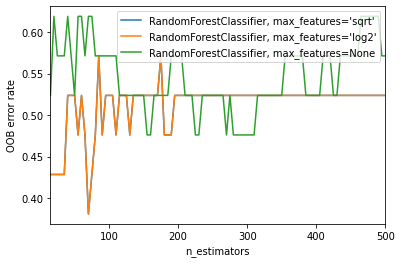

k-fold:  70%|████████████████████████████████████████████████████▌                      | 35/50 [11:09<04:44, 18.94s/it]

0.38095238095238093 70 sqrt
2 122
2 15
2 210
2 13
2 179
2 221
2 131
2 132
2 180
2 133
3 165
3 171
3 148
3 19
3 39
3 153
3 211
3 60
3 110
3 210
1 189
1 49
1 76
1 85
1 113
1 157
1 27
1 194
1 75
1 147
Prediction: [0.37142857 0.62857143] Real: 0

Prediction: [0.77142857 0.22857143] Real: 0

Prediction: [0.61428571 0.38571429] Real: 0

Prediction: [0.47142857 0.52857143] Real: 1

Prediction: [0.31428571 0.68571429] Real: 1

(20, 117)
0.19742815348516865
0.13200218123042898
0.18214470854013243
0.2134084694611018
0.24505079033827784
0.20747218019852032
0.28832347065019853
0.2098561204920096
0.24933051746863172
0.3101003910938486


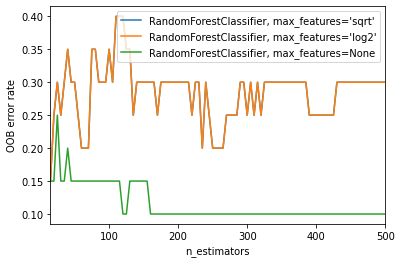

k-fold:  72%|██████████████████████████████████████████████████████                     | 36/50 [11:28<04:24, 18.91s/it]

0.09999999999999998 120 None
7 82
7 83
7 55
7 46
7 70
7 18
7 90
7 33
7 57
7 49
2 85
2 107
2 33
2 5
2 4
2 3
2 104
2 20
2 46
2 26
4 59
4 70
4 103
4 8
4 20
4 102
4 47
4 111
4 67
4 35
Prediction: [0.775 0.225] Real: 1

Prediction: [0.76666667 0.23333333] Real: 1

Prediction: [0.69166667 0.30833333] Real: 0

Prediction: [0.73333333 0.26666667] Real: 0

Prediction: [0.74166667 0.25833333] Real: 0

Prediction: [0.08333333 0.91666667] Real: 1

(21, 508)
0.08893873597184061
0.08201382184021311
0.12582702627732625
0.12330098482524413
0.1173435744120819
0.12570381749168638
0.10946452398210607
0.13257406210867959
0.15166324603677453
0.12319501010983483


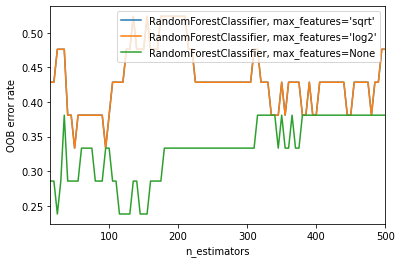

k-fold:  74%|███████████████████████████████████████████████████████▌                   | 37/50 [11:47<04:09, 19.16s/it]

0.23809523809523814 25 None
0 454
0 189
0 259
0 229
0 210
0 452
0 260
0 29
0 453
0 455
6 483
6 109
6 373
6 475
6 188
6 354
6 73
6 451
6 466
6 285
2 228
2 66
2 113
2 302
2 180
2 176
2 170
2 106
2 49
2 4
Prediction: [0.56 0.44] Real: 0

Prediction: [0.92 0.08] Real: 0

Prediction: [0.52 0.48] Real: 1

Prediction: [0.44 0.56] Real: 1

Prediction: [0.44 0.56] Real: 1

(21, 239)
0.12107276812948925
0.13760347114568866
0.15637173022128675
0.11369622173167439
0.16701358607080802
0.17649619758501525
0.15796697662918904
0.18722036730915365
0.18881972734395328
0.21661144191444082


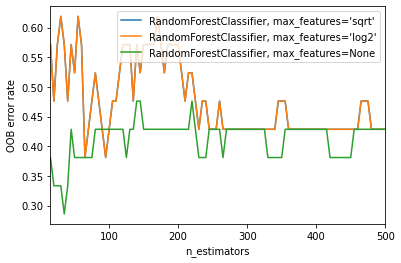

k-fold:  76%|█████████████████████████████████████████████████████████                  | 38/50 [12:06<03:49, 19.13s/it]

0.2857142857142857 35 None
5 23
5 117
5 204
5 190
5 48
5 234
5 118
5 170
5 33
5 34
0 217
0 98
0 120
0 228
0 134
0 148
0 229
0 177
0 71
0 119
4 80
4 128
4 77
4 55
4 71
4 25
4 51
4 202
4 160
4 127
Prediction: [0.28571429 0.71428571] Real: 1

Prediction: [0.82857143 0.17142857] Real: 0

Prediction: [0.85714286 0.14285714] Real: 0

Prediction: [0.74285714 0.25714286] Real: 1

Prediction: [0.85714286 0.14285714] Real: 1

(21, 271)
0.09733304518896574
0.11053923396684173
0.14451545394929138
0.1379132897311837
0.1377527232095374
0.18751932100760282
0.14384734905354157
0.18250320840511114
0.1999770958207439
0.24102616944853342


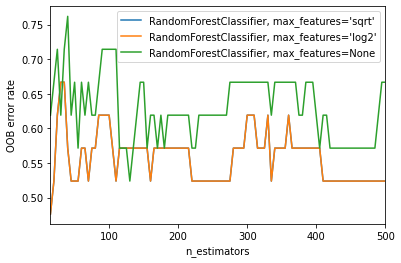

k-fold:  78%|██████████████████████████████████████████████████████████▌                | 39/50 [12:26<03:31, 19.18s/it]

0.47619047619047616 15 sqrt
0 98
0 31
0 150
0 93
0 188
0 213
0 95
0 139
0 94
0 138
7 155
7 225
7 153
7 226
7 250
7 72
7 14
7 15
7 248
7 133
6 49
6 246
6 268
6 267
6 189
6 146
6 252
6 176
6 269
6 0
Prediction: [0.66666667 0.33333333] Real: 0

Prediction: [0.46666667 0.53333333] Real: 0

Prediction: [0.4 0.6] Real: 0

Prediction: [0.4 0.6] Real: 1

Prediction: [0.46666667 0.53333333] Real: 1

(21, 182)
0.14792667764571737
0.18752941456280095
0.15447480178020764
0.22654539483215974
0.2028187493312143
0.12676131930866605
0.17691515867539762
0.20262767547303834
0.179270001220397
0.20959715994860498


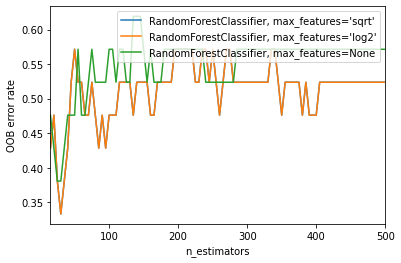

k-fold:  80%|████████████████████████████████████████████████████████████               | 40/50 [12:45<03:11, 19.19s/it]

0.33333333333333337 30 sqrt
5 38
5 29
5 179
5 23
5 173
5 44
5 80
5 153
5 24
5 3
4 110
4 46
4 15
4 47
4 14
4 16
4 107
4 164
4 159
4 56
3 125
3 160
3 80
3 143
3 119
3 152
3 141
3 154
3 33
3 144
Prediction: [0.66666667 0.33333333] Real: 0

Prediction: [0.6 0.4] Real: 0

Prediction: [0.5 0.5] Real: 0

Prediction: [0.16666667 0.83333333] Real: 1

Prediction: [0.3 0.7] Real: 1

(20, 315)
0.09743795037124395
0.12771956430439937
0.1405798742357082
0.12701611225156956
0.15640718531807007
0.16234128545514587
0.18348681203029446
0.1450040377929783
0.13617980198774282
0.13634218384835006


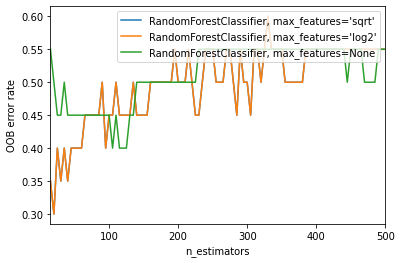

k-fold:  82%|█████████████████████████████████████████████████████████████▍             | 41/50 [13:04<02:53, 19.26s/it]

0.30000000000000004 20 sqrt
4 137
4 35
4 5
4 59
4 9
4 181
4 227
4 182
4 284
4 73
6 25
6 162
6 34
6 47
6 296
6 281
6 212
6 280
6 198
6 282
5 135
5 36
5 110
5 169
5 31
5 70
5 301
5 48
5 98
5 196
Prediction: [0.65 0.35] Real: 1

Prediction: [0.35 0.65] Real: 0

Prediction: [0.75 0.25] Real: 0

Prediction: [0.55 0.45] Real: 0

Prediction: [0.2 0.8] Real: 1

Prediction: [0.15 0.85] Real: 1

(21, 160)
0.15546344922819394
0.1390458916342984
0.1456379339816133
0.19039410568126336
0.2073266017102708
0.21742224592344575
0.20311774808567842
0.28593375168298385
0.19535393097978498
0.17989448221538584


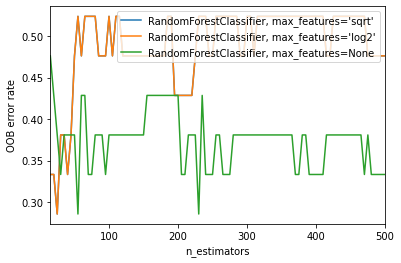

k-fold:  84%|███████████████████████████████████████████████████████████████            | 42/50 [13:24<02:34, 19.32s/it]

0.2857142857142857 25 sqrt
4 94
4 75
4 51
4 18
4 67
4 7
4 143
4 29
4 85
4 137
3 152
3 147
3 117
3 14
3 20
3 123
3 96
3 99
3 114
3 83
5 131
5 92
5 123
5 85
5 154
5 73
5 8
5 64
5 55
5 54
Prediction: [0.56 0.44] Real: 1

Prediction: [0.68 0.32] Real: 0

Prediction: [0.72 0.28] Real: 0

Prediction: [0.48 0.52] Real: 1

Prediction: [0.36 0.64] Real: 1

(21, 160)
0.12291644456365418
0.17632073990785524
0.16412878418478272
0.24043175486442867
0.20331696827506504
0.23129573360821457
0.2524282742635604
0.1638088402551313
0.18309383417995698
0.2447824729703218


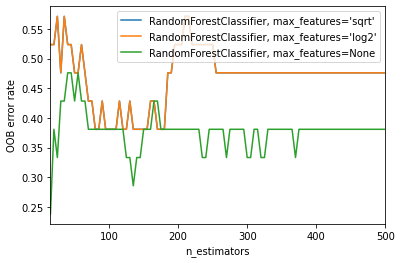

k-fold:  86%|████████████████████████████████████████████████████████████████▌          | 43/50 [13:43<02:15, 19.33s/it]

0.23809523809523814 15 None
2 111
2 10
2 23
2 0
2 139
2 57
2 43
2 93
2 3
2 146
1 15
1 68
1 33
1 78
1 44
1 13
1 32
1 116
1 34
1 142
5 7
5 38
5 84
5 118
5 17
5 76
5 134
5 70
5 99
5 71
Prediction: [0.2 0.8] Real: 1

Prediction: [0.26666667 0.73333333] Real: 0

Prediction: [0.8 0.2] Real: 0

Prediction: [0.13333333 0.86666667] Real: 1

Prediction: [0.26666667 0.73333333] Real: 1

(21, 294)
0.1091021835347638
0.16252837231042652
0.11974078199981998
0.14888970817887556
0.1484511894756907
0.16809631650251697
0.14807404020455384
0.16565726887994986
0.11663234645479172
0.1603854661493248


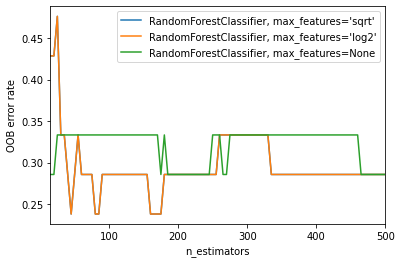

k-fold:  88%|██████████████████████████████████████████████████████████████████         | 44/50 [14:03<01:56, 19.39s/it]

0.23809523809523814 45 sqrt
4 254
4 15
4 293
4 22
4 65
4 289
4 225
4 179
4 180
4 181
2 274
2 99
2 276
2 57
2 272
2 188
2 265
2 187
2 249
2 107
5 212
5 204
5 94
5 281
5 13
5 220
5 146
5 141
5 169
5 209
Prediction: [0.68888889 0.31111111] Real: 0

Prediction: [0.82222222 0.17777778] Real: 0

Prediction: [0.68888889 0.31111111] Real: 0

Prediction: [0.24444444 0.75555556] Real: 1

Prediction: [0.51111111 0.48888889] Real: 1

(21, 312)
0.11384798398885744
0.08301689165505464
0.11937116875092231
0.15919155728896256
0.1223225030308926
0.15319470023466675
0.13159284153131126
0.15717273334979517
0.16329676596458126
0.14802879320101922


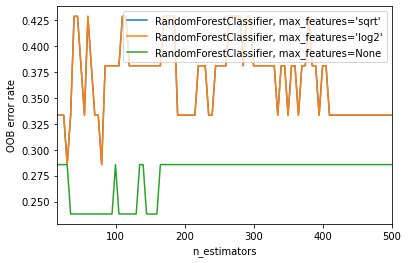

k-fold:  90%|███████████████████████████████████████████████████████████████████▌       | 45/50 [14:22<01:37, 19.41s/it]

0.23809523809523814 35 None
9 149
9 84
9 66
9 106
9 31
9 199
9 200
9 29
9 310
9 82
5 134
5 298
5 98
5 268
5 18
5 279
5 302
5 194
5 110
5 66
0 14
0 152
0 296
0 87
0 86
0 281
0 104
0 259
0 135
0 153
Prediction: [0.65714286 0.34285714] Real: 0

Prediction: [0.6 0.4] Real: 0

Prediction: [0.8 0.2] Real: 0

Prediction: [0.91428571 0.08571429] Real: 1

Prediction: [0.34285714 0.65714286] Real: 1

(20, 179)
0.19717353989860342
0.15972298193441292
0.16934772645764945
0.21171197500478345
0.20513285678207074
0.15998624499794833
0.18720322204150106
0.2313197438041858
0.15979795315249598
0.2237899907442508


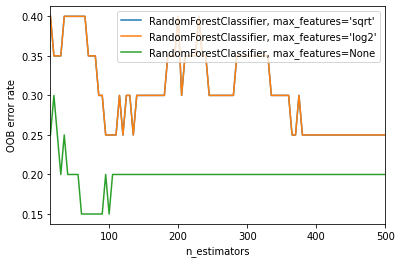

k-fold:  92%|█████████████████████████████████████████████████████████████████████      | 46/50 [14:42<01:17, 19.49s/it]

0.15000000000000002 60 None
9 73
9 131
9 59
9 33
9 164
9 166
9 40
9 165
9 127
9 82
2 111
2 50
2 63
2 117
2 33
2 30
2 12
2 98
2 105
2 0
5 146
5 166
5 30
5 53
5 83
5 99
5 165
5 100
5 164
5 153
Prediction: [0.71666667 0.28333333] Real: 0

Prediction: [0.98333333 0.01666667] Real: 0

Prediction: [0.86666667 0.13333333] Real: 0

Prediction: [0.05 0.95] Real: 1

Prediction: [0.11666667 0.88333333] Real: 1

Prediction: [0.11666667 0.88333333] Real: 1

(21, 495)
0.09038706044397246
0.11102958516885232
0.10626748398756697
0.09811115975641013
0.12090222983471
0.12251542955270935
0.15650207601370283
0.14681853606869263
0.1164459424009299
0.13034150741281106


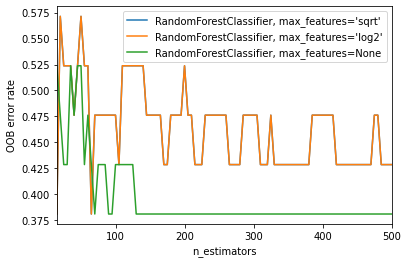

k-fold:  94%|██████████████████████████████████████████████████████████████████████▌    | 47/50 [15:01<00:58, 19.48s/it]

0.38095238095238093 15 sqrt
0 201
0 453
0 183
0 223
0 200
0 250
0 26
0 205
0 206
0 222
2 108
2 292
2 364
2 166
2 334
2 3
2 451
2 154
2 458
2 56
6 277
6 46
6 478
6 13
6 139
6 82
6 97
6 433
6 4
6 333
Prediction: [0.73333333 0.26666667] Real: 0

Prediction: [0.46666667 0.53333333] Real: 0

Prediction: [0.66666667 0.33333333] Real: 1

Prediction: [0.46666667 0.53333333] Real: 1

Prediction: [0.8 0.2] Real: 1

(21, 219)
0.11440932938250653
0.10966735845040201
0.1296518112508002
0.18280208569016534
0.1686623878585879
0.16488272219969582
0.17311045680644477
0.1806812722356329
0.17890063897630776
0.17194977546015255


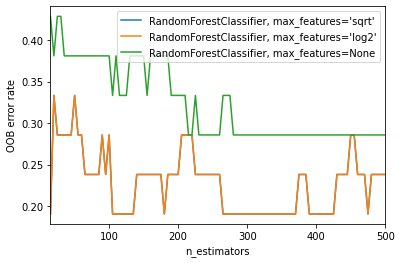

k-fold:  96%|████████████████████████████████████████████████████████████████████████   | 48/50 [15:21<00:38, 19.43s/it]

0.19047619047619047 15 sqrt
8 76
8 204
8 216
8 217
8 48
8 178
8 53
8 165
8 149
8 44
4 100
4 126
4 23
4 192
4 54
4 64
4 141
4 89
4 193
4 144
3 174
3 152
3 56
3 143
3 172
3 8
3 93
3 30
3 3
3 94
Prediction: [0.86666667 0.13333333] Real: 1

Prediction: [0.8 0.2] Real: 1

Prediction: [0.86666667 0.13333333] Real: 0

Prediction: [0.73333333 0.26666667] Real: 0

Prediction: [0.4 0.6] Real: 1

(21, 188)
0.13371490121673893
0.1330148706692233
0.1554267747390495
0.18275614716294275
0.17502328598269662
0.19611024434919969
0.19769791717529644
0.1791898549941089
0.19713111878812592
0.1536868493508329


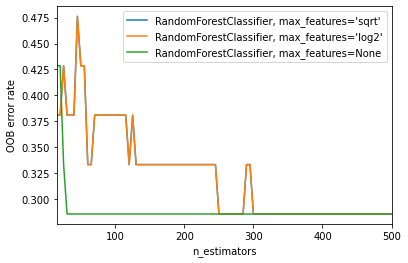

0.2857142857142857 250 sqrt


k-fold:  98%|█████████████████████████████████████████████████████████████████████████▌ | 49/50 [15:40<00:19, 19.46s/it]

4 158
4 10
4 183
4 59
4 185
4 152
4 138
4 162
4 24
4 25
5 58
5 148
5 130
5 67
5 23
5 22
5 82
5 137
5 136
5 2
3 41
3 9
3 56
3 24
3 90
3 25
3 50
3 181
3 135
3 39
Prediction: [0.64 0.36] Real: 0

Prediction: [0.296 0.704] Real: 0

Prediction: [0.54 0.46] Real: 0

Prediction: [0.344 0.656] Real: 1

Prediction: [0.644 0.356] Real: 1

(21, 228)
0.12600442636008397
0.11172022439069428
0.1315277115595644
0.18668877459433086
0.16240759613326847
0.12280247404602976
0.17363482392664334
0.18658279671345476
0.1776245809173281
0.20552509902753438


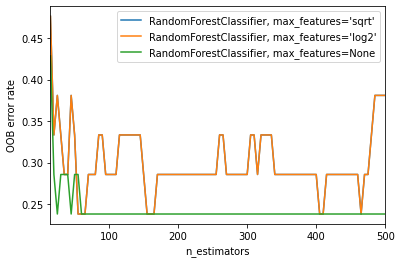

k-fold: 100%|███████████████████████████████████████████████████████████████████████████| 50/50 [16:00<00:00, 19.20s/it]

0.23809523809523814 55 sqrt
5 20
5 170
5 169
5 211
5 168
5 178
5 183
5 175
5 18
5 44
1 155
1 212
1 170
1 104
1 180
1 193
1 70
1 73
1 2
1 174
4 27
4 105
4 158
4 224
4 28
4 84
4 14
4 38
4 77
4 160
Prediction: [0.18181818 0.81818182] Real: 1

Prediction: [0.38181818 0.61818182] Real: 0

Prediction: [0.50909091 0.49090909] Real: 0

Prediction: [0.32727273 0.67272727] Real: 0

Prediction: [0.2 0.8] Real: 1



In [48]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import RocCurveDisplay
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from math import floor
from tqdm import tqdm
from sklearn.decomposition import PCA
import shap

folds = 5

kfold = RepeatedStratifiedKFold(n_splits = folds, n_repeats=10, random_state=42)

methylation_scores_test = np.zeros((26,10))

i = 0

feat_import = []

for train_index, test_index in tqdm(kfold.split(X, y), total=kfold.get_n_splits(), desc="k-fold"):
        
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train_iqr, features = iqr_features(X_train,0.55)
    print(X_train_iqr.shape)
    X_test_iqr = X_test.loc[:,features]
    
    pca = PCA(n_components=10)
    X_train_iqr = pca.fit_transform(X_train_iqr)
    X_test_iqr = pca.transform(X_test_iqr)
    
    pca_feats = []
    
    for row in pca.components_:
        print(np.max(row))
        top_feats = np.argpartition(row, -10)[-10:]
        pca_feats.append(top_feats)
            
    #print(pca_feats)
    
    min_oob, trees, max_feats, errors = oob_rf_params(X_train_iqr,y_train)
    
    if "sqrt" in max_feats: max_feats = "sqrt"
    elif "log2" in max_feats: max_feats = "log2"
    else: max_feats = None
        
    print(min_oob, trees, max_feats)
    
    model = RandomForestClassifier(n_estimators=trees,max_features=max_feats)
    model.fit(X_train_iqr,y_train)
    
    feats = model.feature_importances_
    
    best_pca = np.argpartition(feats, -3)[-3:]
    
    for val in best_pca:
        for index in pca_feats[val]:
            print(val, index)
            feat_import.append([features[index],pca.components_[val][index],feats[val],pca.components_[val][index]*feats[val]])
            
    #print(feat_import)

    for pred,label in zip(model.predict_proba(X_test_iqr),test_index):
        methylation_scores_test[label][floor(i/folds)] = pred[1]
    
    for a, b in zip(model.predict_proba(X_test_iqr), y_test):
        print("Prediction: "+str(a)+" Real: "+str(b)+"\n")
    i += 1

In [ ]:
feature_df_new = pd.DataFrame(np.row_stack(feat_import))

In [ ]:
np.argpartition(feature_df[3], -3)[-3:]

In [ ]:
feature_df.iloc[323,:]

In [ ]:
for row in feature_df[0]:
    if row == "cg27517502":
        print("here")

In [ ]:
np.sum(feature_df_new[0].value_counts() > 15)

In [ ]:
feature_df[0].value_counts().nlargest(8)

In [ ]:
feature_df_new[0].value_counts().nlargest(8)

In [ ]:
for val in feature_df_new[0]:
    if val in ESR1:
        print("Yes")

In [ ]:
feature_df_new[0]

In [ ]:
feature_df_new.iloc[984,:]

In [ ]:
feature_df_new[3] = feature_df_new[3].astype(float)

In [ ]:
feature_df_max_import = feature_df_new.groupby(0).sum()

In [ ]:
feature_df_max_import.loc["cg17682313"]

In [ ]:
np.argmax(feature_df_max_import[3])

In [ ]:
feature_df_max_import.iloc[327]

In [ ]:
max_sum = np.argpartition(feature_df_max_import[3], -10)[-10:].to_list()

In [ ]:
for val in max_sum:
    print(feature_df_max_import.iloc[val])

In [9]:
pd_arr = X.iloc[np.arange(-23, len(X)-23)]
pd_arr_y = labels["endocrine response"].iloc[np.arange(-23, len(X)-23)]

In [83]:
occ_methyl_all

[0.3,
 0.5,
 0.9,
 0.1,
 0.6,
 0.3,
 0.3,
 0.2,
 0.6,
 0.2,
 0.2,
 0.3,
 0.4,
 0.5,
 0.1,
 0.1,
 0.4,
 0.6,
 0.8,
 0.8,
 0.9,
 0.2,
 0.8,
 0.7,
 0.8,
 0.8]

In [75]:
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()

plt_labels = {"index": "Patients","value": "Beta value","color":"Response"}

fig = px.bar(pd_arr.loc[:,"cg15412519"],color=pd_arr_y,labels=plt_labels,title="cg15412519 (No gene) Beta value")
fig.update_yaxes(range=[0, 1.0])
fig.show()

In [49]:
mean = np.mean(methylation_scores_test, axis=1)

mean_list = []
for element in mean:
    mean_list.append([element])
    
labelled_scores = np.append(methylation_scores_test, mean_list, axis=1)
labelled_scores_mean = np.append(labelled_scores, [[0.8],[0.8],[0.8],[0.2],[0.2],[0.2],[0.2],[0.2],[0.2],[0.2],[0.2],[0.2],[0.2],[0.2],[0.2],[0.2],[0.8],[0.8],[0.8],[0.8],[0.8],[0.8],[0.8],[0.8],[0.8],[0.8]], axis = 1)

<AxesSubplot:>

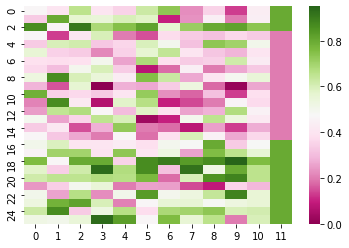

In [50]:
sns.heatmap(labelled_scores_mean,cmap="PiYG")

0.7692307692307693


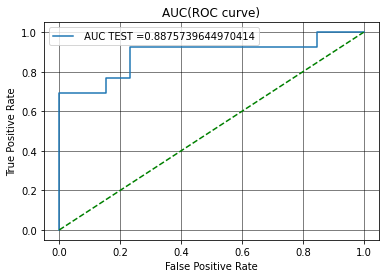

In [51]:
from sklearn.metrics import roc_curve, auc, accuracy_score

#train_fpr, train_tpr, tr_thresholds = roc_curve(y,methylation_scores_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y,labelled_scores_mean[:,-2])

plt.grid()

acc = []
for val in labelled_scores_mean[:,-2]:
    acc.append(0) if val < 0.5 else acc.append(1)

print(accuracy_score(y, acc))

#plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [52]:
unmatched_label = ["C00217","C00218","C00219","C00214","C00215","C00209"]
y_common = y.drop(unmatched_label)

matched_scores = []

for row,label in zip(labelled_scores_mean,y.index):
    if label not in unmatched_label:
        matched_scores.append(row)
        
matched_scores = np.array(matched_scores)

In [53]:
occ = []

for row in matched_scores[:,:-2]:
    k = 0
    for item in row:
        if item >= 0.5: k+=1
            
    occ.append(k/10)

<AxesSubplot:>

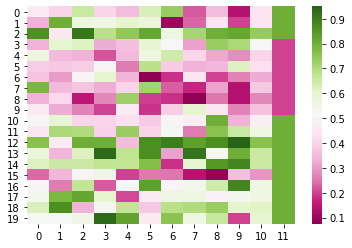

In [54]:
sns.heatmap(matched_scores,cmap="PiYG")

In [67]:
diverse = [3,6,7,11,12]

In [69]:
labelled_scores_mean[diverse]

array([[0.46666667, 0.13333333, 0.40740741, 0.6       , 0.2       ,
        0.15      , 0.37142857, 0.33333333, 0.31111111, 0.36      ,
        0.33332804, 0.2       ],
       [0.38461538, 0.37777778, 0.38333333, 0.5       , 0.25833333,
        0.68      , 0.38214286, 0.33333333, 0.34285714, 0.61818182,
        0.4260575 , 0.2       ],
       [0.36666667, 0.30140845, 0.5       , 0.6       , 0.33684211,
        0.075     , 0.18181818, 0.44      , 0.2       , 0.26666667,
        0.32684021, 0.2       ],
       [0.20882353, 0.86666667, 0.41818182, 0.06666667, 0.57777778,
        0.66666667, 0.1       , 0.14285714, 0.2       , 0.46      ,
        0.37076403, 0.2       ],
       [0.24615385, 0.64761905, 0.67272727, 0.46666667, 0.3       ,
        0.58      , 0.38333333, 0.25833333, 0.28      , 0.67272727,
        0.45075608, 0.2       ]])

0.75


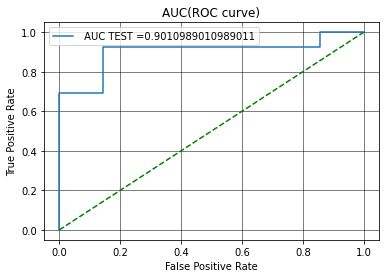

In [56]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

#train_fpr, train_tpr, tr_thresholds = roc_curve(y,methylation_scores_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_common,matched_scores[:,-2])

plt.grid()

acc = []
for val in matched_scores[:,-2]:
    acc.append(0) if val < 0.5 else acc.append(1)

print(accuracy_score(y_common, acc))

#plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [66]:
matched_scores

array([[0.46666667, 0.4       , 0.65454545, 0.4       , 0.35      ,
        0.62637363, 0.73333333, 0.225     , 0.35      , 0.13333333,
        0.43392524, 0.8       ],
       [0.33333333, 0.8       , 0.56666667, 0.55      , 0.6       ,
        0.58      , 0.1       , 0.23333333, 0.44      , 0.2       ,
        0.44033333, 0.8       ],
       [0.864     , 0.45925926, 0.90909091, 0.68539326, 0.74736842,
        0.82      , 0.56363636, 0.71428571, 0.8       , 0.81818182,
        0.73812157, 0.8       ],
       [0.33333333, 0.6       , 0.61481481, 0.325     , 0.35789474,
        0.5956044 , 0.50357143, 0.30833333, 0.73333333, 0.704     ,
        0.50758854, 0.2       ],
       [0.56      , 0.34814815, 0.33333333, 0.21797753, 0.34736842,
        0.56666667, 0.64333333, 0.4       , 0.32      , 0.28333333,
        0.40201608, 0.2       ],
       [0.38461538, 0.37777778, 0.38333333, 0.5       , 0.25833333,
        0.68      , 0.38214286, 0.33333333, 0.34285714, 0.61818182,
        0.4260575 ,

In [57]:
def occ(scores,thresh):
    
    occ = []

    for row in scores[:,:-2]:
        k = 0
        for item in row:
            if item >= thresh: k+=1
            
        occ.append(k/10)
        
    return occ

0.8


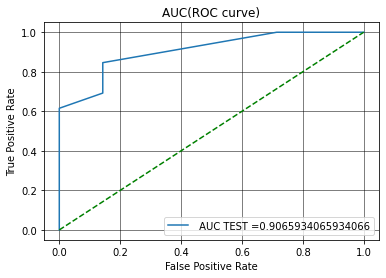

In [64]:
occ_methyl = occ(matched_scores,0.5)

#train_fpr, train_tpr, tr_thresholds = roc_curve(y,methylation_scores_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_common,occ_methyl)

plt.grid()

acc = []
for val in occ_methyl:
    acc.append(0) if val < 0.5 else acc.append(1)

print(accuracy_score(y_common, acc))

#plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [65]:
occ_methyl

[0.3,
 0.5,
 0.9,
 0.6,
 0.3,
 0.3,
 0.2,
 0.2,
 0.1,
 0.1,
 0.4,
 0.6,
 0.8,
 0.8,
 0.9,
 0.2,
 0.8,
 0.7,
 0.8,
 0.8]

0.7692307692307693


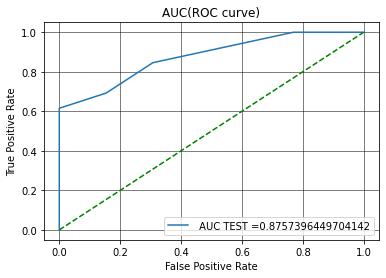

In [59]:
occ_methyl_all = occ(labelled_scores_mean,0.5)

#train_fpr, train_tpr, tr_thresholds = roc_curve(y,methylation_scores_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y,occ_methyl_all)

plt.grid()

acc = []
for val in occ_methyl_all:
    acc.append(0) if val < 0.5 else acc.append(1)

print(accuracy_score(y, acc))

#plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [60]:
occ_methyl

[0.3,
 0.5,
 0.9,
 0.6,
 0.3,
 0.3,
 0.2,
 0.2,
 0.1,
 0.1,
 0.4,
 0.6,
 0.8,
 0.8,
 0.9,
 0.2,
 0.8,
 0.7,
 0.8,
 0.8]

In [61]:
occ_methyl_all

[0.3,
 0.5,
 0.9,
 0.1,
 0.6,
 0.3,
 0.3,
 0.2,
 0.6,
 0.2,
 0.2,
 0.3,
 0.4,
 0.5,
 0.1,
 0.1,
 0.4,
 0.6,
 0.8,
 0.8,
 0.9,
 0.2,
 0.8,
 0.7,
 0.8,
 0.8]